# Library

In [2]:
from fastai.vision.all import * 
from fastbook import * 
matplotlib.rc('image', cmap='Greys')

/Users/phucbb/opt/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/phucbb/opt/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Dataset

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
!ls {path}

testing  training


In [6]:
threes = (path/'training'/'3').ls().sorted()

In [ ]:
Image.open(threes[1])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

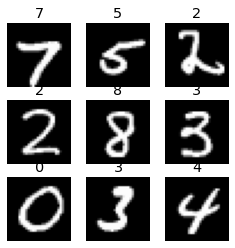

In [9]:
# define dataloaders
mnist = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                    get_y=parent_label)
dls = mnist.dataloaders(path, device=device)
# get a batch of data
dls.show_batch(max_n=9, figsize=(4,4))

In [10]:
first = next(iter(dls.valid))
first[0].shape, first[1].shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

In [14]:
simple_net = nn.Sequential(
    # flatten the input
    nn.Flatten(1),
    nn.Linear(28*28*3,30),
    nn.ReLU(),
    nn.Linear(30,10)
)

In [15]:
with torch.no_grad():
    print(simple_net(first[0]).shape)

torch.Size([64, 10])


In [17]:

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy,
                metrics=accuracy)
learn.fit_one_cycle(2, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.270426,0.239989,0.932000,02:03
1,0.215431,0.203011,0.942200,02:12


In [18]:
# print model stats
learn.model
# print number of parameters and ops/s
learn.summary()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'total parameters: {total_params}')
total_trainable_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'total trainable parameters: {total_trainable_params}')

total parameters: 70900
total trainable parameters: 70900


In [20]:
def conv(ni, nf, ks=3, act=True): 
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) 
    if act: res = nn.Sequential(res, nn.ReLU()) 
    return res

In [21]:
simple_cnn = nn.Sequential(
    conv(3, 8, ks=5), #14
    conv(8, 16), #7
    conv(16, 32), #4
    conv(32, 32), #2
    conv(32, 10, act=False), #1
    nn.Flatten()
)

In [ ]:
# simple_cnn = sequential( 
#                         conv(3 ,4), #14x14 
#                         conv(4 ,8), #7x7 
#                         conv(8 ,16), #4x4 
#                         conv(16,32), #2x2 
#                         conv(32,1, act=False), #1x1 
#                         Flatten(), )

In [22]:
with torch.no_grad():
    print(simple_cnn(first[0]).shape)

torch.Size([64, 10])


In [23]:
# train the model
# def loss_fn(preds, targets):
#     # cross entropy loss
#     return nn.BCEWithLogitsLoss()(preds, targets.float().unsqueeze(-1))
def loss_fn(preds, targets):
    # cross entropy loss
    return nn.CrossEntropyLoss()(preds, targets.float().unsqueeze(-1))

learn = Learner(dls, simple_cnn, opt_func=SGD,
                loss_func=F.cross_entropy,
                metrics=accuracy)
learn.fit_one_cycle(2, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.177435,0.134976,0.956600,02:12
1,0.107052,0.089893,0.970700,02:03


In [24]:
# print model training stats
learn.model
print("model summary")
print("trainable parameters: ", learn.summary())

model summary


trainable parameters:  Sequential (Input shape: 64 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 14 x 14    
Conv2d                                    608        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 7 x 7     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 4 x 4     
Conv2d                                    4640       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    9248       True      
ReLU                   

In [25]:
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'total parameters: {total_params}')
total_trainable_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'total trainable parameters: {total_trainable_params}')

total parameters: 18554
total trainable parameters: 18554


In [29]:
# bechmark model inference speed
import time
def time_model_inference(model, dls, bs = 64, n = 10):
    # time model inference
    start = time.time()
    # with batch size of 64
    dls.bs = bs
    for batch in dls.valid:
        model(batch[0])
    end = time.time()
    print(f'elapsed time: {end-start}')

In [30]:
time_model_inference(learn.model, dls, bs=64)

elapsed time: 10.929362058639526


In [31]:
time_model_inference(learn.model, dls, bs=1)

elapsed time: 16.602117776870728


In [32]:
time_model_inference(learn.model, dls, bs=128)

elapsed time: 10.094799280166626


In [33]:
# benchmark model training speed batch size in range 1 to 128
for bs in range(1, 129, 2):
    time_model_inference(learn.model, dls, bs=bs)

elapsed time: 13.771751165390015
elapsed time: 19.666527032852173
elapsed time: 13.421298742294312
elapsed time: 19.030250072479248
elapsed time: 13.252860069274902
elapsed time: 13.879606008529663
elapsed time: 25.9507999420166
elapsed time: 18.03598189353943
elapsed time: 21.839240789413452


KeyboardInterrupt: 